# Overfit and Underfit

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit

## Import Keras

In [1]:
import tensorflow as tf

from tensorflow.keras import layers

print(tf.__version__)

2.4.1


In [2]:
!pip install -q git+https://github.com/tensorflow/docs

In [3]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [4]:
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

In [5]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

FEATURES = 28

ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

In [7]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

In [8]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


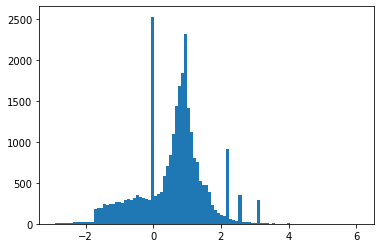

In [9]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins = 101)

In [10]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [11]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [12]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [13]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

### Overfitting

### Training Procedure

In [14]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, 
    decay_steps=STEPS_PER_EPOCH * 1000, 
    decay_rate=1,
    staircase=False
)

In [15]:
def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

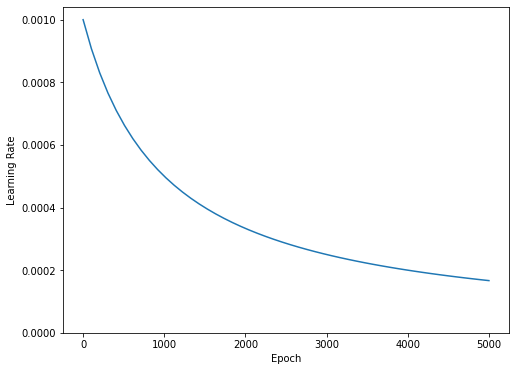

In [16]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize = (8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [17]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
        tf.keras.callbacks.TensorBoard(logdir / name),
    ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.losses.BinaryCrossentropy(
                from_logits=True, 
                name='binary_crossentropy'
            ),
            'accuracy'
        ]
    )
    
    model.summary()
    
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    
    return history

In [19]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

size_histories = {}

size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4654,  binary_crossentropy:0.7973,  loss:0.7973,  val_accuracy:0.4980,  val_binary_crossentropy:0.7386,  val_loss:0.7386,  
....................................................................................................
Epoch: 100, accuracy:0.5843,  binary_crossentropy:0.6316,  loss:0.6316,  val_accuracy:0.5760,  val_binary_crossentropy:0.6319,  val_loss:0.6319,  
....................................................................................................
Epoch: 200, accuracy:0.60

(0.5, 0.7)

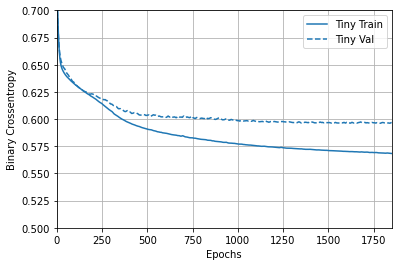

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small Model

In [21]:
small_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [22]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4854,  binary_crossentropy:0.7819,  loss:0.7819,  val_accuracy:0.4970,  val_binary_crossentropy:0.7215,  val_loss:0.7215,  
....................................................................................................
Epoch: 100, accuracy:0.6135,  binary_crossentropy:0.6163,  loss:0.6163,  val_accuracy:0.5890,  val_binary_crossentropy:0.6157,  val_loss:0.

### Medium Model

In [23]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

In [24]:
size_histories['Medium'] = compile_and_fit(medium_model, 'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4957,  binary_crossentropy:0.6930,  loss:0.6930,  val_accuracy:0.4920,  val_binary_crossentropy:0.6808,  val_loss:0.6808,  
....................................................................................................
E

### Large Model

In [25]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1),
])

In [ ]:
size_histories['large'] = compile_and_fit(large_model, 'sizes/large')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5089,  binary_crossentropy:0.7916,  loss:0.7916,  val_accuracy:0.4610,  val_binary_crossentr

### Plot the training and validation losses

In [ ]:
plotter.plot(size_histories)
a = plt.xsacle('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

#### Draw the model input output relationship

In [57]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

In [58]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

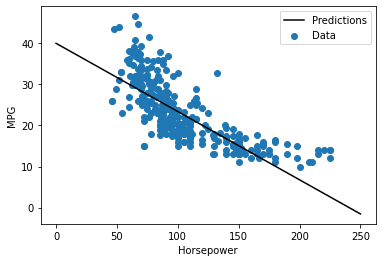

In [59]:
plot_horsepower(x, y)

### Multiple Inputs Model

In [60]:
linear_model = tf.keras.Sequential([
    normalizer, # use fully parameters normalizer input layer
    layers.Dense(units=1)
])

In [61]:
linear_model.predict(train_features[:10])

array([[-0.332],
       [-0.407],
       [-0.857],
       [-1.58 ],
       [ 1.026],
       [-0.954],
       [ 1.065],
       [ 2.634],
       [-0.394],
       [ 2.304]], dtype=float32)

In [62]:
linear_model.layers[1].kernel

<tf.Variable 'dense_2/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.492],
       [-0.362],
       [-0.09 ],
       [ 0.567],
       [ 0.395],
       [-0.574],
       [ 0.598],
       [ 0.424],
       [-0.352]], dtype=float32)>

In [64]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

In [67]:
%%time

epochs = 100

history = linear_model.fit(
    train_features,
    train_labels,
    epochs=epochs,
    verbose=0,
    validation_split=0.2
)

Wall time: 4.78 s


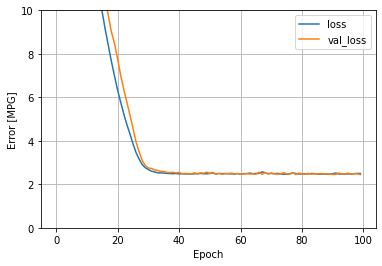

In [68]:
plot_loss(history)

In [69]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=0)

## DNN Regression

In [70]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(
        loss='mean_absolute_error',
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
    )
    
    return model

### One Variable

In [90]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [91]:
dnn_horsepower_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_2 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 16,900
Trainable params: 16,897
Non-trainable params: 3
_________________________________________________________________


In [92]:
%%time

epochs=100

history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    verbose=0,
    epochs=epochs,
    validation_split=0.2
)

Wall time: 5.55 s


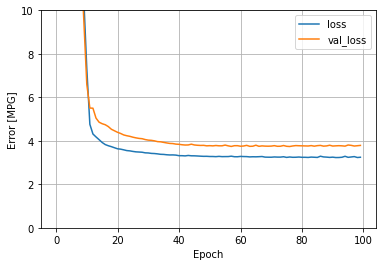

In [94]:
plot_loss(history)

In [95]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

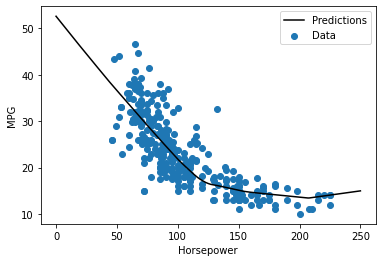

In [96]:
plot_horsepower(x, y)

In [97]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

### Full Parameters Model

In [98]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 9)                 19        
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 17,940
Trainable params: 17,921
Non-trainable params: 19
_________________________________________________________________


In [101]:
%%time

epochs=100

history = dnn_model.fit(
    train_features,
    train_labels,
    verbose=0,
    epochs=epochs,
    validation_split=0.2
)

Wall time: 5.43 s


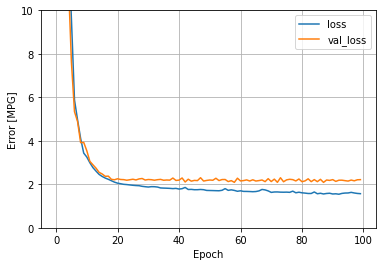

In [102]:
plot_loss(history)

In [104]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance Summary

In [106]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649389
linear_model,2.465422
dnn_horsepower_model,2.877020
dnn_model,1.662053


### Predictions

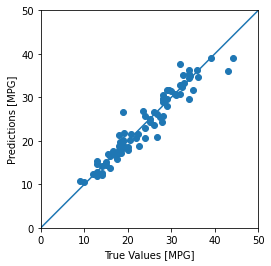

In [108]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

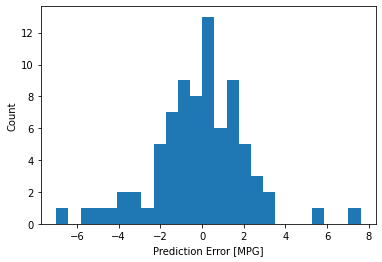

In [109]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

### Model Benchmark

In [111]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model\assets


In [112]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [113]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.649389
linear_model,2.465422
dnn_horsepower_model,2.877020
dnn_model,1.662053
reloaded,1.662053


## Conclusions

To prevent overfitting in NN:
    * Get trianing sample
    * Reduce NN capacity
    * Weight Regularization
    * Dropout